In [1]:
import re
import json

In [3]:
with open('data/Top10_Communities.json', encoding='utf-8-sig') as f:
    data = json.load(f)
    
with open('data/Conference_Id_name.json',encoding='utf-8-sig') as f:
    conference_data = json.load(f)

In [4]:
conference_data_dict = dict()
for conf_data in conference_data:
    conference_data_dict[conf_data['Id_Venue']] = conf_data['conference name']

conference_data_dict

{30: 'international conference of the ieee engineering in medicine and biology society',
 65: 'robot and human interactive communication',
 104: 'symposium on principles of database systems',
 122: 'acm sigplan symposium on principles and practice of parallel programming',
 208: 'mobile adhoc and sensor systems',
 235: 'international conference on computational linguistics',
 256: 'international conference on learning representations',
 293: 'passive and active network measurement',
 339: 'computer and communications security',
 343: 'hot topics in networks',
 344: 'conference of the european chapter of the association for computational linguistics',
 369: 'vehicular technology conference',
 374: 'european symposium on research in computer security',
 390: 'international symposium on biomedical imaging',
 422: 'knowledge discovery and data mining',
 507: 'international conference on management of data',
 517: 'international conference on software testing verification and validation',
 

In [5]:
import re
import random
import numpy as np
import pandas as pd 
from pprint import pprint
from collections import Counter, OrderedDict

import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import pyLDAvis
from pyLDAvis import gensim_models

from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import plotly.express as px


%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  

stop_words = set(stopwords.words('english'))
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"
lmtzr = WordNetLemmatizer()

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


In [6]:
def color_func(**kwargs):
    return "hsl(0, {}%, 50%)".format(random.randint(0, 50))

In [7]:
papers = pd.DataFrame(data)
papers.dropna(inplace=True)
papers.head()

ID_Article  communityId  ID_RelatedVenue  \
0     2897211        21220               30   
1     2950694        21235               30   
2     2922123        21235               30   
3     2921960        21235               30   
4     2981319        21246               30   

                                               title  year  \
0  A wide range and high sensitivity four-channel...  2016   
1  Recent machine learning advancements in sensor...  2016   
2  Automatic grasp selection using a camera in a ...  2016   
3  Automatic tissue characterization of air trapp...  2016   
4  Unified phase variables of relative degree two...  2016   

                                            abstract  
0  We present a four-channel, high-sensitivity an...  
1  The development of wearable sensors has opened...  
2  In this paper, we demonstrate how automatic gr...  
3  Significant progress has been made in recent y...  
4  A starting point to achieve stable locomotion ...

In [8]:
papers['communityId'].value_counts()

21220    13607
21349    13468
21239    12344
22736    11616
21246    10947
21212    10306
20178    10049
21235     8606
22457     7875
21258     3506
Name: communityId, dtype: int64

In [9]:
# Input Community to perform analysis on
community_id_to_use = 22736

In [10]:
df = papers[papers['communityId'] == community_id_to_use]
df.head()

ID_Article  communityId  ID_RelatedVenue  \
8      2924059        22736               30   
9      2923951        22736               30   
10     2919831        22736               30   
15     2938410        22736               30   
16     2929546        22736               30   

                                                title  year  \
8   Development of a finger-like mechanism of end-...  2016   
9   Accuracy assessment and kinematic calibration ...  2016   
10  A self-aligning knee joint for walking assista...  2016   
15  Design of a bio-inspired pneumatic artificial ...  2016   
16  Design and development of a sensorized cylindr...  2016   

                                             abstract  
8   Neurosurgery had been considered nearly imposs...  
9   This paper explores the general stereotactic a...  
10  This paper presents a novel self-aligning knee...  
15  Pneumatic artificial muscles (PAMs) are one of...  
16  Aim of this work is to design and develop an i...

We will first take a look at the papers in the community disributed by the year they were published in and see if we can find any patterns in it. 

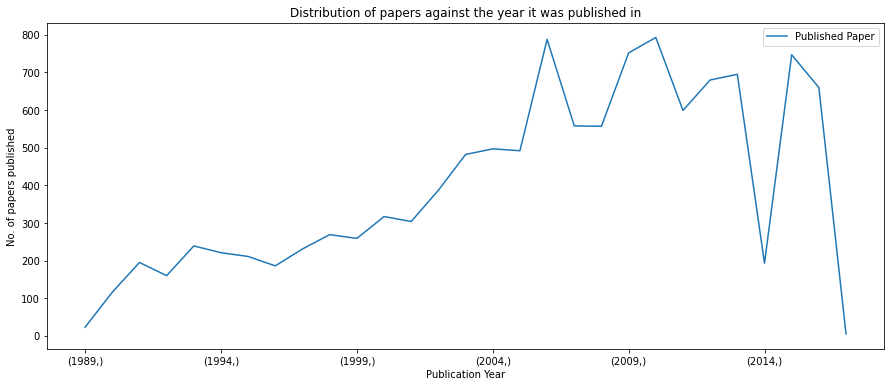

In [11]:
ax = df[['year']].sort_values(by='year').value_counts(sort=False).plot( 
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the year it was published in')
ax.set_xlabel('Publication Year')
ax.set_ylabel('No. of papers published')
plt.legend(["Published Paper"])

We see that most of the papers in the community were published in the years after 2004 with year 2011 accounting for the highest number of papers.

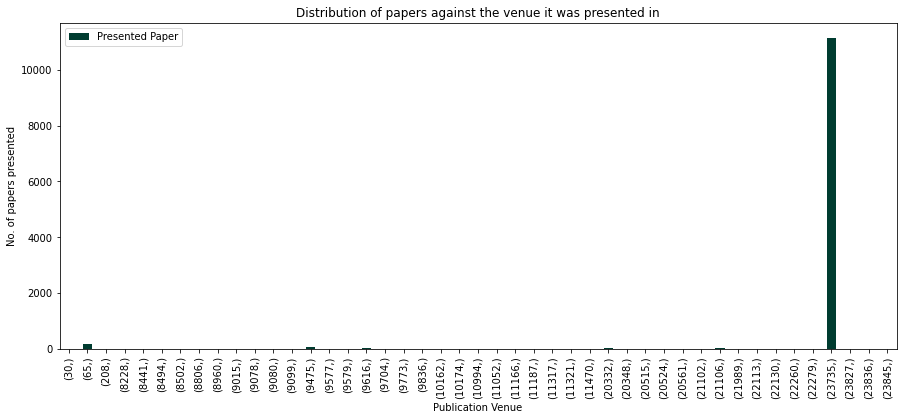

In [12]:
ax = df[['ID_RelatedVenue']].value_counts(sort=False).plot(kind='bar',colormap = 'BrBG_r',
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the venue it was presented in')
ax.set_xlabel('Publication Venue')
ax.set_ylabel('No. of papers presented')
plt.legend(["Presented Paper"])

In [13]:
conference_data_dict[23735]

'intelligent robots and systems'

One interesting thing we can note here is that most papers of the community were presented at the same venue. The venue_id where majority of the papers were presented is 23735 which corresponds to the **Intelligent Robots and Systems**, Hence most of the papers in the community are from that conference. We should be expecting papers about robotics and its applications.

In [14]:
plot_df = pd.DataFrame()

## Analyzing the title of the papers

We will initially plot a wordcloud of the 1000 most used terms in the titles of the papers of the community and see which are the most commonly used words in the titles of the papers

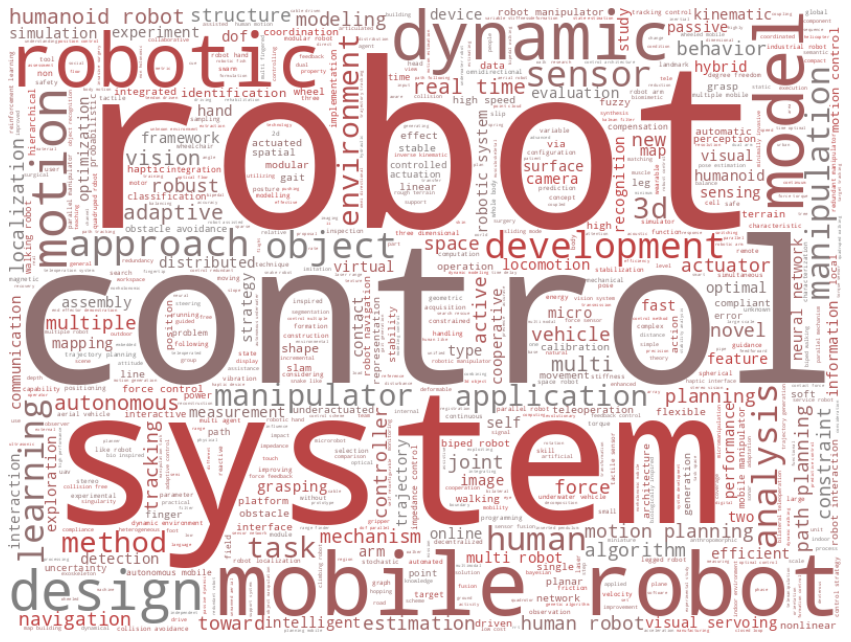

In [15]:
stop_words.update(['based', 'using', 'A', 'The'])

plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['title'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)
all_titles = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_titles)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

Looking at the wordcloud, we can see that a lot of papers of the community focus on images and videos models and algorithms. Since most papers of the community were presented at a conference about image processing, the results definitely are what we expect it to be like. Next we take a look at top 30 words and the number of times they have been used in the paper titles.

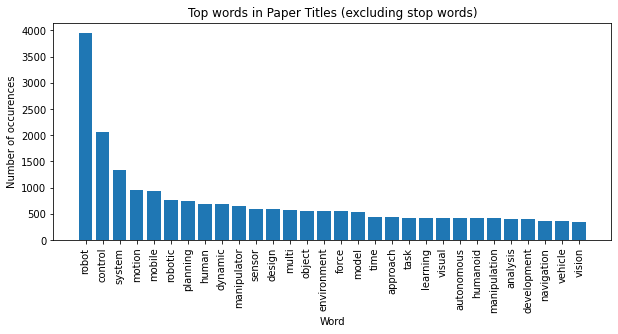

In [16]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])


count_vectorizer = CountVectorizer(stop_words=stop_words)
words, word_values = get_top_n_words(n_top_words=30,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=plot_df['col'])

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in Paper Titles (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Top words in the paper titles are robot, control, motion and so on. Considering most papers are about remote sensing and geo spatial data, the results are consistent.

We apply Latent Discriminant Analysis (LDA) for topic modelling using only the titles of the papers

In [17]:
dictionary = corpora.Dictionary(plot_df['tokenized_col'])
texts = plot_df['tokenized_col']
corpus = [dictionary.doc2bow(text) for text in plot_df['tokenized_col']]

In [18]:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [19]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [20]:
lda.show_topics(total_topics,6)

[(0,
  '0.065*"robot" + 0.022*"time" + 0.021*"real" + 0.019*"control" + 0.017*"walking" + 0.015*"motion"'),
 (1,
  '0.055*"robot" + 0.024*"mobile" + 0.018*"inspired" + 0.018*"self" + 0.013*"wheeled" + 0.013*"modular"'),
 (2,
  '0.037*"visual" + 0.026*"robot" + 0.017*"3d" + 0.017*"servoing" + 0.017*"object" + 0.016*"autonomous"'),
 (3,
  '0.064*"control" + 0.049*"robot" + 0.037*"manipulator" + 0.015*"force" + 0.015*"task" + 0.013*"system"'),
 (4,
  '0.051*"system" + 0.046*"robot" + 0.017*"robotic" + 0.016*"control" + 0.016*"sensor" + 0.013*"multi"'),
 (5,
  '0.055*"robot" + 0.027*"control" + 0.025*"network" + 0.024*"mobile" + 0.020*"planning" + 0.018*"neural"'),
 (6,
  '0.036*"robot" + 0.024*"control" + 0.021*"hand" + 0.014*"learning" + 0.012*"robotic" + 0.011*"human"'),
 (7,
  '0.028*"control" + 0.025*"system" + 0.023*"robot" + 0.017*"robotic" + 0.011*"performance" + 0.010*"environment"'),
 (8,
  '0.053*"robot" + 0.043*"human" + 0.030*"learning" + 0.021*"interaction" + 0.017*"interface

The above list of tuples show which terms are most important to which topic. The numbers attached to each term represents the weightages given to that term for the corresponding topic.

In [21]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

robot      time      real   control   walking    motion  parallel  \
0  0.065150  0.022472  0.021072  0.018744  0.016546  0.014909  0.013599   
1  0.054697  0.000000  0.000000  0.010576  0.000000  0.007411  0.000000   
2  0.026478  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.048527  0.007514  0.000000  0.064068  0.000000  0.000000  0.000000   
4  0.046482  0.000000  0.000000  0.016492  0.000000  0.010007  0.000000   
5  0.054988  0.000000  0.000000  0.027044  0.000000  0.008669  0.000000   
6  0.036215  0.000000  0.000000  0.023521  0.000000  0.000000  0.000000   
7  0.023368  0.000000  0.000000  0.028375  0.000000  0.000000  0.000000   
8  0.053272  0.000000  0.000000  0.013215  0.000000  0.000000  0.000000   
9  0.020202  0.000000  0.000000  0.013673  0.008836  0.031713  0.000000   

      biped      high  kinematics  ...   tactile  contact     range  \
0  0.011746  0.010614    0.009246  ...  0.000000  0.00000  0.000000   
1  0.000000  0.000000    0.000000  ...  0.000000  0.00000  0.000000   
2  0.000000  0.000000    0.000000  ...  0.000000  0.00000  0.000000   
3  0.000000  0.000000    0.000000  ...  0.000000  0.00000  0.000000   
4  0.000000  0.000000    0.000000  ...  0.000000  0.00000  0.000000   
5  0.000000  0.000000    0.000000  ...  0.000000  0.00000  0.000000   
6  0.000000  0.000000    0.000000  ...  0.000000  0.00000  0.000000   
7  0.000000  0.000000    0.000000  ...  0.000000  0.00000  0.000000   
8  0.000000  0.000000    0.000000  ...  0.005908  0.00000  0.000000   
9  0.000000  0.000000    0.000000  ...  0.000000  0.01579  0.012102   

   generation   optimal      body     point   surface     micro   driven  
0     0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  
1     0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  
2     0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  
3     0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  
4     0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  
5     0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  
6     0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  
7     0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  
8     0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  
9     0.01031  0.009825  0.009104  0.008075  0.007978  0.007033  0.00657  

[10 rows x 144 columns]

The score for each term in the above dataframe denotes how important that term is to the topic which is represented from numbers 0 to 9. A higher score of a term in a particular topic row indicates that that term is of high importance to that topic.

Next, we will plot a heatmap representing the similarities and correlations between terms present in the titles of the different papers. This allows us to see which words or terms are highly correlated and which are not. A darker shade of red between two terms represents that they are very highly correlated with one another.

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


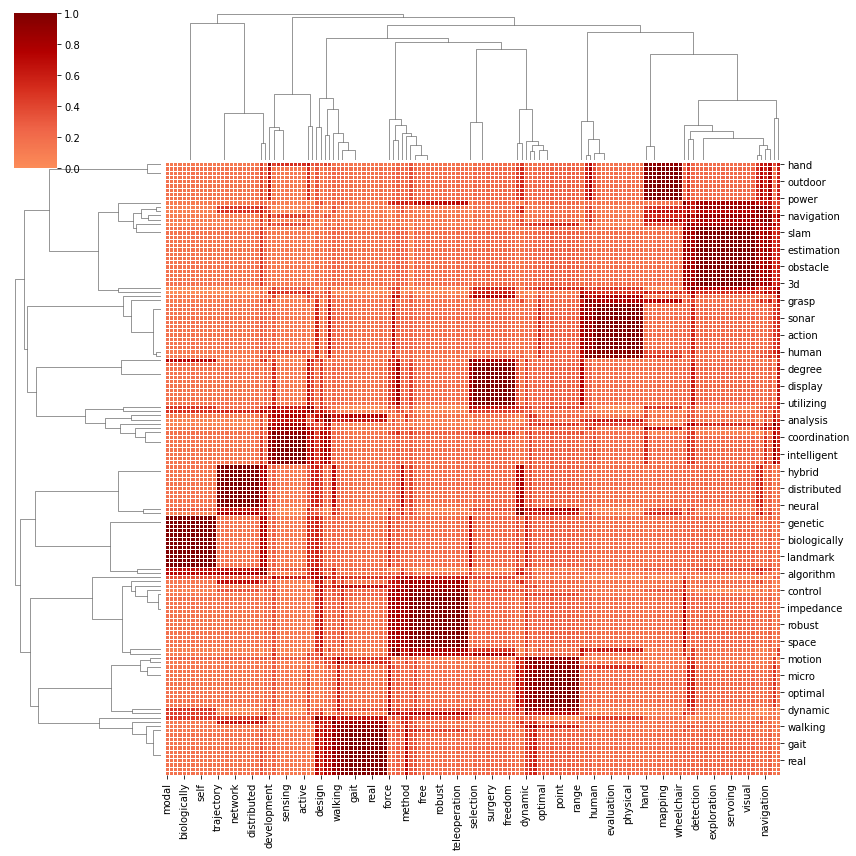

In [22]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [23]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
9      32.420952   8.115230       1        1  40.287718
5       0.648955  71.707100       2        1   9.780593
7      71.019684   9.971006       3        1   8.232145
4       3.785981  33.185135       4        1   7.789881
6     -42.666500  -9.222070       5        1   7.449728
0      -3.621689 -43.526516       6        1   6.445983
8      -3.632402  -4.171708       7        1   5.004060
1     -36.584400  35.804413       8        1   5.003340
2      44.391380  50.615383       9        1   5.003335
3      40.235809 -31.591665      10        1   5.003219, topic_info=             Term        Freq       Total Category  logprob  loglift
79          robot  407.000000  407.000000  Default  30.0000  30.0000
65        control  222.000000  222.000000  Default  29.0000  29.0000
783   manipulator   70.000000   70.000000  Default  28.0000  28.0000
15         system  164.000000  164.000000  Default  27.0000  27.0000
89          human   62.000000   62.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
195      multiple    4.066362   35.788915  Topic10  -4.9623   0.8202
566       dynamic    4.805509  150.564913  Topic10  -4.7953  -0.4495
591      flexible    3.537613   18.082894  Topic10  -5.1016   1.3636
320        mobile    3.736771  107.023032  Topic10  -5.0468  -0.3597
97   manipulation    3.710676   96.672040  Topic10  -5.0538  -0.2650

[731 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
627       5  0.917307        2d
43        1  0.444244        3d
43        2  0.074041        3d
43        3  0.049360        3d
43        4  0.049360        3d
...     ...       ...       ...
1987      3  0.931316      wire
3402      2  0.897211  wireless
1689      6  0.813982    within
3509      9  0.917288   working
786       1  0.913792      zero

[1340 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 8, 5, 7, 1, 9, 2, 3, 4])

The above plot is a 2D mapped visualization of the distances between each of the generated topics through LDA. Hovering the mouse above a particular circle (which represents a topic) allows us to see important terms and words that make up that topic.

NOTE: Relevance is denoted by λ, the weight assigned to the probability of a term in a topic relative to its lift. When λ = 1, the terms are ranked by their probabilities within the topic (the ‘regular’ method) while when λ = 0, the terms are ranked only by their lift. Lift is the ratio of a term’s probability within a topic to its margin probability across the corpus.

Next we will take a look at some of the paper titles with maximum correspondence to the top topic words.

In [24]:
titles = plot_df['col'].values

count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(titles)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [25]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [26]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  formulation, integrating, face, operational, dextrous, door, avoiding, spline, finding, mixed, fixed, regression, arbitrary, modulation, perceptual

Paper Titles:
Where to Build a Door
Group induction
Model reduction for fork/join overhaul & repair systems with rotable inventory
Visual shock absorber based on maxwell model for anti-rebound control

****************************************************************************************************
TOPIC 1:
Top Words:  surgery, wire, car, invasive, minimally, end, computer, teleoperated, jumping, brain, biological, effector, assisted, comparative, situation

Paper Titles:
Operability study on the multisensory illusion inducible in microsurgical robotic systems
A bimanual teleoperated system for endonasal skull base surgery
A guide dog robot Harunobu-5-following a person
Row following in pergola structured orchards

****************************************************************************************************
T

## Analyzing the abstracts of the papers

In [27]:
# stop_words.update(['based', 'using', 'A', 'The'])
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"

## Cleaning the text of the abstract to remove or ignore unimportant symbols and characters
plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['abstract'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (re.sub(latex_regex, "", row['tokenized_col'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)

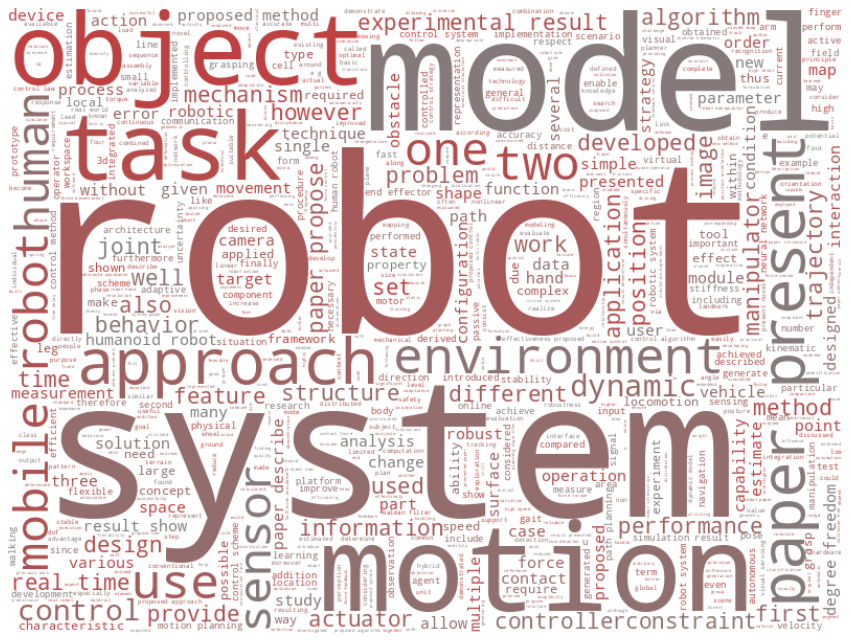

In [28]:
all_abstracts = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_abstracts)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

As expected, the word cloud from abstracts of the papers are pretty similar to that of the titles with pretty much the same words having higher frequencies of occurences in the abstracts.

### Ngram Analysis of Abstracts

In [29]:
def count_ngrams(dataframe,column,begin_ngram,end_ngram): 
    word_vectorizer = CountVectorizer(ngram_range=(begin_ngram,end_ngram), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(dataframe[column].dropna())
    frequencies = sum(sparse_matrix).toarray()[0]
    most_common = pd.DataFrame(frequencies, 
                               index=word_vectorizer.get_feature_names(), 
                               columns=['frequency']).sort_values('frequency',ascending=False)
    most_common['ngram'] = most_common.index
    most_common.reset_index()
    return most_common

def word_cloud_function(df,column,number_of_words):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    word_string=str(popular_words_nonstop)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=number_of_words,
                          width=1000,height=1000,
                         ).generate(word_string)
    plt.clf()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def word_bar_graph_function(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

In [30]:
two_grams = count_ngrams(plot_df,'col',2, 2)

fig = px.bar(two_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 2-Words in Abstracts of Papers',
             orientation='h')
fig.show()

In [31]:
three_grams = count_ngrams(plot_df,'col',3, 3)

fig = px.bar(three_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 3-Words in Abstracts of Papers',
             orientation='h')
fig.show()

For abstract, instead of using single words for topic modelling, we will be using ngrams in the range of [1,3]. Through this way, we should be able to capture more context from the abstract texts of the papers.

In [32]:
ngrams = Phrases(plot_df['tokenized_col'].values, min_count=1, threshold=3, delimiter=' ')

ngrams_phraser = Phraser(ngrams)

ngram_token = []
for sent in plot_df['tokenized_col'].values:
    ngram_token.append(ngrams_phraser[sent])

In [33]:
dictionary = corpora.Dictionary(ngram_token)
corpus = [dictionary.doc2bow(text) for text in ngram_token]

tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [34]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [35]:
lda.show_topics(total_topics, 7)

[(0,
  '0.009*"robot" + 0.006*"approach" + 0.006*"model" + 0.006*"method" + 0.005*"system" + 0.004*"sensor" + 0.004*"problem"'),
 (1,
  '0.014*"robot" + 0.013*"sensor" + 0.011*"system" + 0.008*"model" + 0.007*"control" + 0.007*"method" + 0.006*"proposed"'),
 (2,
  '0.021*"robot" + 0.008*"motion" + 0.005*"mobile robot" + 0.005*"rover" + 0.003*"algorithm" + 0.003*"obstacle" + 0.003*"wheel"'),
 (3,
  '0.016*"system" + 0.015*"robot" + 0.012*"model" + 0.011*"motion" + 0.010*"method" + 0.010*"control" + 0.009*"task"'),
 (4,
  '0.007*"approach" + 0.006*"robot" + 0.006*"system" + 0.006*"vehicle" + 0.004*"algorithm" + 0.004*"motion" + 0.004*"use"'),
 (5,
  '0.051*"robot" + 0.015*"human" + 0.013*"environment" + 0.009*"task" + 0.008*"behavior" + 0.008*"motion" + 0.006*"system"'),
 (6,
  '0.014*"robot" + 0.013*"algorithm" + 0.011*"method" + 0.007*"path" + 0.007*"environment" + 0.006*"map" + 0.005*"obstacle"'),
 (7,
  '0.036*"object" + 0.020*"robot" + 0.010*"image" + 0.010*"method" + 0.005*"approac

In [36]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

robot  approach     model    method    system    sensor   problem  \
0  0.009272  0.006343  0.005548  0.005524  0.004633  0.003580  0.003571   
1  0.013578  0.004260  0.007997  0.006935  0.010699  0.013389  0.000000   
2  0.020913  0.002505  0.000000  0.002374  0.001627  0.001861  0.002068   
3  0.015014  0.006066  0.012270  0.010273  0.015549  0.000000  0.003747   
4  0.006335  0.006757  0.000000  0.003286  0.005773  0.000000  0.000000   
5  0.050829  0.004449  0.005046  0.002774  0.006335  0.000000  0.000000   
6  0.013864  0.004586  0.000000  0.011364  0.003593  0.000000  0.004145   
7  0.019758  0.005179  0.004903  0.009620  0.002766  0.000000  0.005011   
8  0.004074  0.000000  0.001883  0.001585  0.001749  0.000000  0.000000   
9  0.018058  0.000000  0.003957  0.004058  0.030627  0.000000  0.003194   

   landmark  paper present  proposed  ...   protein  single cell  assembling  \
0   0.00337       0.003029  0.002910  ...  0.000000     0.000000    0.000000   
1   0.00000       0.003357  0.006080  ...  0.000000     0.000000    0.000000   
2   0.00000       0.001751  0.000000  ...  0.000000     0.000000    0.000000   
3   0.00000       0.003327  0.005457  ...  0.000000     0.000000    0.000000   
4   0.00000       0.000000  0.000000  ...  0.000000     0.000000    0.000000   
5   0.00000       0.002759  0.000000  ...  0.000000     0.000000    0.000000   
6   0.00000       0.002683  0.002497  ...  0.000000     0.000000    0.000000   
7   0.00000       0.000000  0.000000  ...  0.000000     0.000000    0.000000   
8   0.00000       0.000000  0.002185  ...  0.001586     0.001563    0.001525   
9   0.00000       0.003716  0.006191  ...  0.000000     0.000000    0.000000   

     design  mechanism  structure      also    module  actuator  experiment  
0  0.000000   0.000000   0.000000  0.000000  0.000000  0.000000    0.000000  
1  0.000000   0.000000   0.000000  0.000000  0.000000  0.000000    0.000000  
2  0.000000   0.000000   0.000000  0.000000  0.000000  0.000000    0.000000  
3  0.000000   0.000000   0.000000  0.000000  0.000000  0.000000    0.000000  
4  0.000000   0.000000   0.000000  0.000000  0.000000  0.000000    0.000000  
5  0.000000   0.000000   0.000000  0.000000  0.000000  0.000000    0.000000  
6  0.000000   0.000000   0.000000  0.000000  0.000000  0.000000    0.000000  
7  0.000000   0.000000   0.000000  0.000000  0.000000  0.000000    0.000000  
8  0.000000   0.000000   0.000000  0.000000  0.000000  0.000000    0.000000  
9  0.007327   0.006015   0.003848  0.003598  0.003347  0.003212    0.003044  

[10 rows x 105 columns]

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



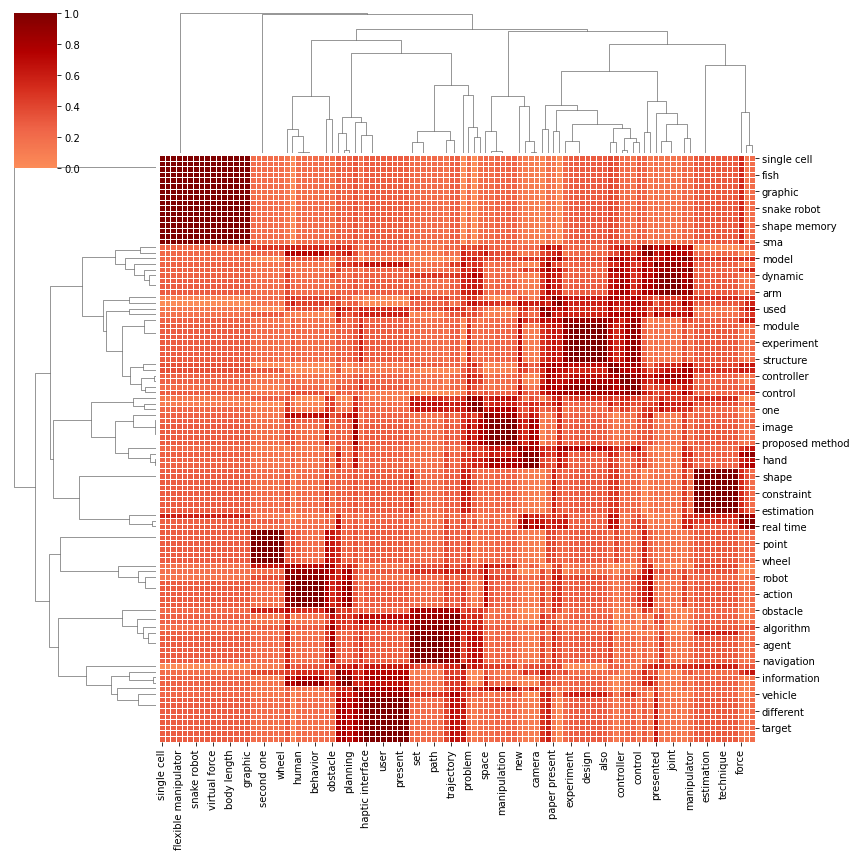

In [37]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [38]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.



PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  20.201587
3       0.648955  71.707100       2        1  19.835377
1      71.019684   9.971006       3        1  11.176853
9       3.785981  33.185135       4        1  10.137164
8     -42.666500  -9.222070       5        1   8.392906
4      -3.621689 -43.526516       6        1   6.878016
7      -3.632402  -4.171708       7        1   5.846306
5     -36.584400  35.804413       8        1   5.845564
6      44.391380  50.615383       9        1   5.845174
2      40.235809 -31.591665      10        1   5.841054, topic_info=             Term        Freq       Total Category  logprob  loglift
143         robot  175.000000  175.000000  Default  30.0000  30.0000
279        object   43.000000   43.000000  Default  29.0000  29.0000
104        system  112.000000  112.000000  Default  28.0000  28.0000
268         human   23.000000   23.000000  Default  27.0000  27.0000
727   environment   42.000000   42.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
268         human    1.100246   23.655482  Topic10  -6.4243  -0.2278
1172   trajectory    1.021846   20.811585  Topic10  -6.4983  -0.1736
895    navigation    0.962378   10.284743  Topic10  -6.5582   0.4712
104        system    1.103931  112.694535  Topic10  -6.4210  -1.7855
509       dynamic    0.986375   30.511643  Topic10  -6.5336  -0.5916

[828 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
303        1  0.127013          2
303        2  0.254025          2
303        3  0.127013          2
303        4  0.127013          2
303        7  0.127013          2
...      ...       ...        ...
766        7  0.068490       work
766        8  0.068490       work
766        9  0.068490       work
766       10  0.068490       work
30213      1  0.852755  workpiece

[1141 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 10, 9, 5, 8, 6, 7, 3])

In [39]:
abstracts = plot_df['col'].values

count_vectorizer = CountVectorizer(ngram_range=(1,3))
counts = count_vectorizer.fit_transform(abstracts)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [40]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [41]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  avateering, displaying robot, emotional gait, virtual room, retro projected, emotional gait pattern, allocation procedure, projected face, 3d sample, refractive index discontinuity, index discontinuity, formation control cooperative, among agent formation, could conceived basis, control cooperative exploration

Paper Titles:
Enhancing the robot avateering metaphor discreetly with an assistive agent and its effect on perception
Affective recruitment of distributed heterogeneous agents
Towards retro-projected robot faces: An alternative to mechatronic and android faces
Design of a therapeutic robotic companion for relational, affective touch

****************************************************************************************************
TOPIC 1:
Top Words:  3d mmt, gaze guidance, micromagnetic tool, micromagnetic, order investigate psychological, investigate psychological, mfam, regulation selected, vision task minimization, combine regulation, task function app

In [42]:
def get_representative_papers(H, W, feature_names, title_list, no_top_words, no_top_documents):
    representative_df = pd.DataFrame()
    for topic_idx, topic in enumerate(H):
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            representative_df = representative_df.append(df.iloc[doc_index])
    return representative_df
            
no_top_words = 30
no_top_documents = 350     
tf_feature_names = count_vectorizer.get_feature_names()
representative_df = get_representative_papers(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)
representative_df.drop_duplicates(inplace=True)
for col in ['ID_Article', 'communityId', 'ID_RelatedVenue', 'year']:
    representative_df[col] = representative_df[col].astype('int')

In [43]:
representative_df.to_csv("CSV_files/repr_22736.csv", index=False)
representative_df

ID_Article  communityId  ID_RelatedVenue  \
209        1199315        22736               65   
95412        57827        22736            20332   
144        1881493        22736               65   
74         2506984        22736               65   
93540        66667        22736            11187   
...            ...          ...              ...   
193        1335976        22736               65   
114393     1370722        22736            23735   
123        2047852        22736               65   
124        2101249        22736               65   
116205      845990        22736            23735   

                                                    title  year  \
209     Enhancing the robot avateering metaphor discre...  2014   
95412   Affective recruitment of distributed heterogen...  2004   
144     Towards retro-projected robot faces: An altern...  2009   
74      Design of a therapeutic robotic companion for ...  2005   
93540   Animal vibrissae: modeling and adaptive contro...  2013   
...                                                   ...   ...   
193     Tactile sensing: Steps to artificial somatosen...  2010   
114393  On internal models for representing tactile in...  2010   
123     A novel variable impedance compact compliant s...  2012   
124     Improvements of the sound perception processin...  2005   
116205  A human adaptive path tracking method for omni...  2005   

                                                 abstract  
209     We present a modeling approach to develop an a...  
95412   Members of multi-robot teams may need to colla...  
144     This paper presents a new implementation of a ...  
74      Much research has shown the positive health be...  
93540   The reception of vibrations is a special sense...  
...                                                   ...  
193     In this paper a framework for representing tac...  
114393  In this paper a framework for representing tac...  
123     This paper presents the analysis of electro-me...  
124     The development of the anthropomorphic flutist...  
116205  This work presents a new path tracking method ...  

[1021 rows x 6 columns]